In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"


from evo.notebooks import ServiceManagerWidget, FeedbackWidget
from evo.objects.typed import object_from_uuid, object_from_path
import evo.compute.tasks as tasks

In [2]:
manager = await ServiceManagerWidget.with_auth_code(
    client_id="core-compute-tasks-notebooks",  # Replace with your client ID
    base_uri="https://qa-ims.bentley.com",
    discovery_url="https://int-discover.test.api.seequent.com",
    cache_location="./notebook-data",
).login()

ServiceManagerWidget(children=(VBox(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR…

In [3]:
comps = await object_from_path(manager, "Ag_LMS1 - Ag_ppm Values.json")
grid = await object_from_path(manager, "Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79.json")
variogram = await object_from_path(manager, "Kriging Compute Task/Ag_LMS1: Variogram Model.json")

In [4]:
comps #html repr spacing is grooooowwwwwwwinnnnggg

In [5]:
comps_df = await comps.to_dataframe()

In [6]:
pd.DataFrame(comps_df['Ag_ppm Values'].describe())

Ag_ppm Values
count    4791.000000
mean      110.035929
std        76.335792
min         2.475000
25%        49.701200
50%       101.414000
75%       150.356000
max      1302.910000

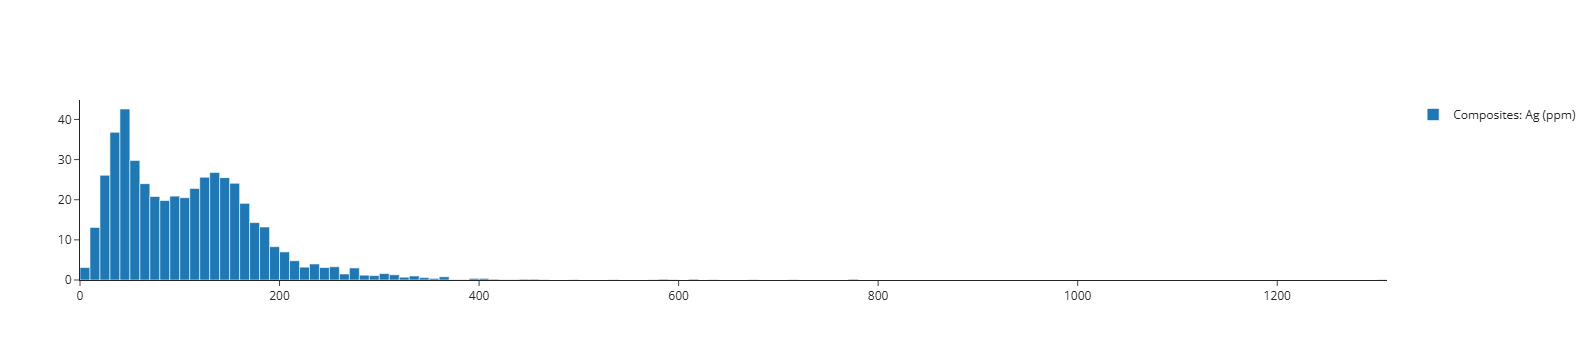

In [7]:
comps_hist = go.Histogram(x=comps_df['Ag_ppm Values'], histnorm='density', name='Composites: Ag (ppm)', showlegend=True)
go.Figure(comps_hist)

In [8]:
variogram # Rotation order: dip_azimuth, dip, pitch, math for std sill looks suspect

In [13]:
1211/3462

0.34979780473714617

In [15]:
variogram.get_ellipsoid() #should default to structure with longest range

Ellipsoid(ranges=EllipsoidRanges(major=134.0, semi_major=90.0, minor=40.0), rotation=Rotation(dip_azimuth=100.0, dip=65.0, pitch=75.0))

In [12]:
variogram.get_variogram_curves(200) # get_principal_directions , max_distance

(VariogramCurveData(distance=array([  0.        ,   1.00502513,   2.01005025,   3.01507538,
          4.0201005 ,   5.02512563,   6.03015075,   7.03517588,
          8.04020101,   9.04522613,  10.05025126,  11.05527638,
         12.06030151,  13.06532663,  14.07035176,  15.07537688,
         16.08040201,  17.08542714,  18.09045226,  19.09547739,
         20.10050251,  21.10552764,  22.11055276,  23.11557789,
         24.12060302,  25.12562814,  26.13065327,  27.13567839,
         28.14070352,  29.14572864,  30.15075377,  31.15577889,
         32.16080402,  33.16582915,  34.17085427,  35.1758794 ,
         36.18090452,  37.18592965,  38.19095477,  39.1959799 ,
         40.20100503,  41.20603015,  42.21105528,  43.2160804 ,
         44.22110553,  45.22613065,  46.23115578,  47.2361809 ,
         48.24120603,  49.24623116,  50.25125628,  51.25628141,
         52.26130653,  53.26633166,  54.27135678,  55.27638191,
         56.28140704,  57.28643216,  58.29145729,  59.29648241,
         60.

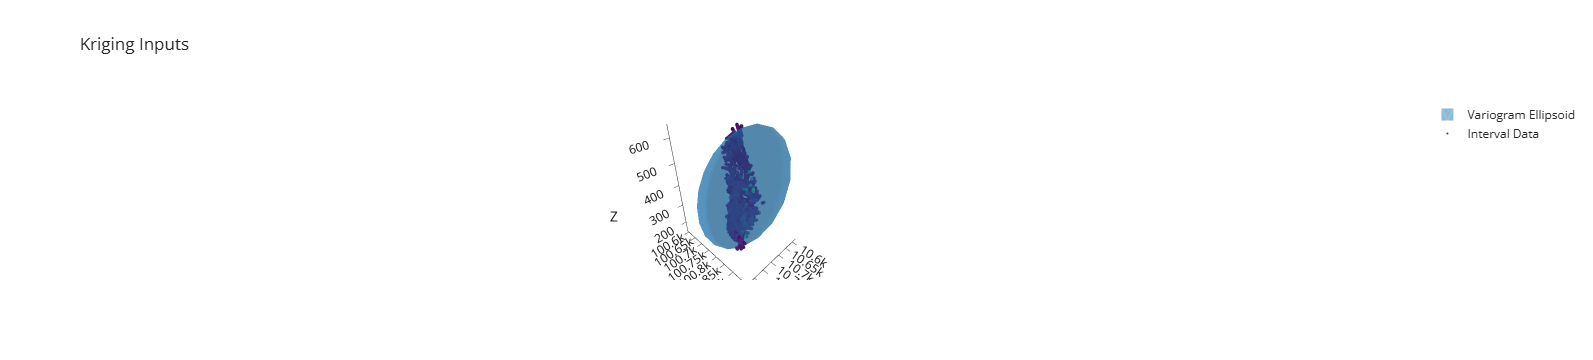

In [23]:
center = (comps_df.x.mean(), comps_df.y.mean(), comps_df.z.mean())
ell = variogram.get_ellipsoid().scaled(2)
ell_points = np.array(ell.surface_points(center=center)).T # why isn't this an array?

ell_mesh = go.Mesh3d(
    x=ell_points[:, 0],
    y=ell_points[:, 1],
    z=ell_points[:, 2],
    alphahull=1, opacity=0.5, name="Variogram Ellipsoid", showlegend=True)

scatter = go.Scatter3d(
    x=comps_df['x'],
    y=comps_df['y'],
    z=comps_df['z'],
    mode='markers',
    marker=dict(size=2, color=comps_df['Ag_ppm Values']), name="Interval Data")

go.Figure(data=[ell_mesh, scatter], layout=go.Layout(
    title="Kriging Inputs",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ), showlegend=True
))


In [24]:
grid

In [28]:
kriging_params = tasks.kriging.KrigingParameters(
    source=comps.attributes["Ag_ppm Values"],
    target=tasks.Target.new_attribute(object=grid, attribute_name="kriged_grade ag 5"), # WIP
    variogram=variogram,
    search=tasks.SearchNeighborhood(
        ellipsoid=ell,
        max_samples=20,
    ),
)

In [30]:
estimator_job = await tasks.run(manager, kriging_params)

In [43]:
estimator_job #add blocksync/evo link + evo viewer - unfortunately no access to attr via url in viewer

✓ Kriging Result
  Message:   Kriging completed.
  Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
  Attribute: kriged_grade ag 4

In [34]:
grid = await grid.refresh()

In [39]:
grid_df = await grid.get_data(['kriged_grade ag 5'])

In [41]:
grid_df['kriged_grade ag 5'].describe()

pd.DataFrame([comps_df['Ag_ppm Values'].describe(), grid_df['kriged_grade ag 5'].describe()]).T

Ag_ppm Values  kriged_grade ag 5
count    4791.000000        7492.000000
mean      110.035929         110.809518
std        76.335792          52.046531
min         2.475000          15.055810
25%        49.701200          78.025040
50%       101.414000         107.932342
75%       150.356000         135.306375
max      1302.910000         450.328027

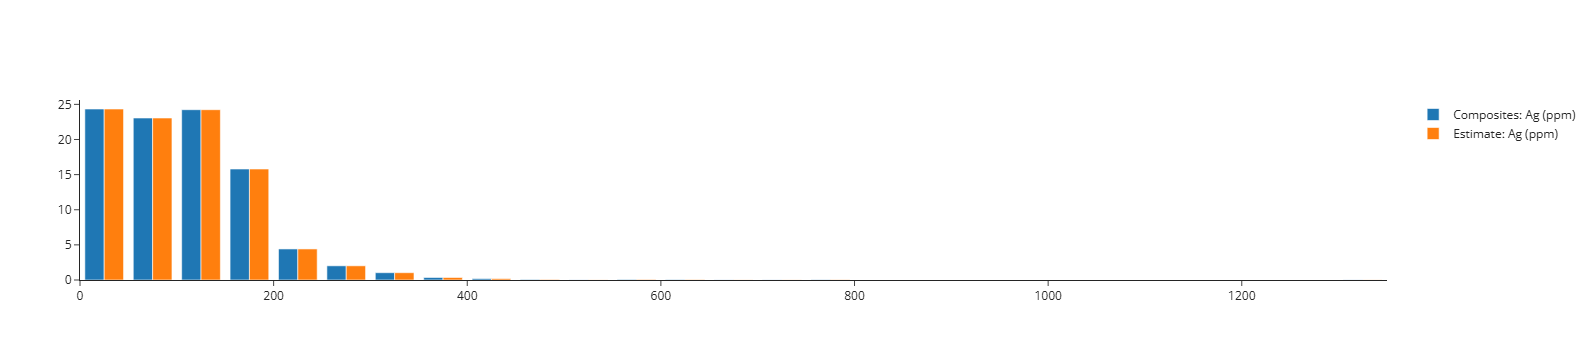

In [42]:
est_hist = go.Histogram(x=comps_df['Ag_ppm Values'], 
                        histnorm='density', name='Estimate: Ag (ppm)', showlegend=True, nbinsx=50)
go.Figure([comps_hist, est_hist])

In [45]:
max_samples_values =[1, 3, 5,15,25,35,55]
parameter_sets = []
for max_samples in max_samples_values:
    params = tasks.kriging.KrigingParameters(
        source=comps.attributes["Ag_ppm Values"],
        target=grid['test'],
        variogram=variogram,
        search=tasks.SearchNeighborhood(ellipsoid=ell, max_samples=max_samples),
    )
    parameter_sets.append(params)
    print(f"Prepared scenario with max_samples={max_samples}")

print(f"\nCreated {len(parameter_sets)} parameter sets")

TypeError: 'BlockModel' object is not subscriptable

In [88]:
tasks.run_multiple?

Signature:
tasks.run_multiple(
    context: 'IContext',
    parameters: 'list[TParams]',
    run_fn: 'Callable[[IContext, TParams], Awaitable[TResult]]',
    *,
    fb: 'IFeedback' = <evo.common.utils.feedback._NoFeedback object at 0x7574fcf2e510>,
) -> 'list[TResult]'
Docstring:
Run multiple compute tasks concurrently with aggregated feedback.

This is a generic utility for running multiple instances of any compute task
in parallel. Progress is aggregated across all tasks.

Args:
    context: The context providing connector and org_id
    parameters: List of parameter objects for each task instance
    run_fn: The async function to run for each parameter set.
            Should have signature: async (context, params) -> result
    fb: Feedback interface for progress updates

Returns:
    List of results in the same order as the input parameters

Example:
    >>> from evo.compute.tasks import run_kriging, KrigingParameters
    >>> from evo.compute.tasks.common import run_multiple
    >

In [89]:
results = await tasks.run_kriging_multiple(manager, parameter_sets, fb=FeedbackWidget("why do i need a label"))

In [90]:
results # this could look nicer

[✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=1,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=3,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=5,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=15,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=25,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79
   Attribute: EBDs Samples=35,
 ✓ Kriging Result
   Message:   Kriging completed.
   Target:    Kriging Scenarios - 

In [91]:
await grid.refresh()

In [92]:
grid.attributes

BlockModelAttributes(['version_id', 'Samples=5', 'Samples=20', 'Samples=10', 'Samples=15', 'kriged_grade ag', 'kriged_grade ag 1', 'EBD Samples=25', 'EBD Samples=5', 'EBD Samples=15', 'EBD Samples=35', 'EBD Samples=55'])

In [93]:
grid = await grid.refresh()

In [94]:
grid.attributes

BlockModelAttributes(['version_id', 'Samples=5', 'Samples=20', 'Samples=10', 'Samples=15', 'kriged_grade ag', 'kriged_grade ag 1', 'EBD Samples=25', 'EBD Samples=5', 'EBD Samples=15', 'EBD Samples=35', 'EBD Samples=55', 'EBD Samples=1', 'EBD Samples=3', 'EBDs Samples=3', 'EBDs Samples=1', 'EBDs Samples=15', 'EBDs Samples=5', 'EBDs Samples=25', 'EBDs Samples=35', 'EBDs Samples=55'])

In [72]:
new_cols = [i for i in grid.attributes if i.name.startswith('EBD')]

In [78]:
grid_df = await grid.get_data(columns=[i.name for i in new_cols])

In [82]:
estimates = grid_df.drop(['x','y','z'], axis=1)

In [83]:
estimates.describe()

EBD Samples=25  EBD Samples=5  EBD Samples=15  EBD Samples=35  \
count      458.000000     458.000000      458.000000      458.000000   
mean       101.728305     101.034092      101.532089      101.776488   
std         65.882155      67.749673       65.737779       65.967707   
min          6.206630       6.206630        6.206630        6.206630   
25%         50.325226      49.258535       50.325226       50.325226   
50%         95.096448      92.588884       95.096448       95.096448   
75%        138.093898     139.239367      137.908520      138.093898   
max        533.304044     533.304044      533.304044      533.304044   

       EBD Samples=55  
count      458.000000  
mean       101.791817  
std         65.963227  
min          6.206630  
25%         50.325226  
50%         95.096448  
75%        138.093898  
max        533.304044

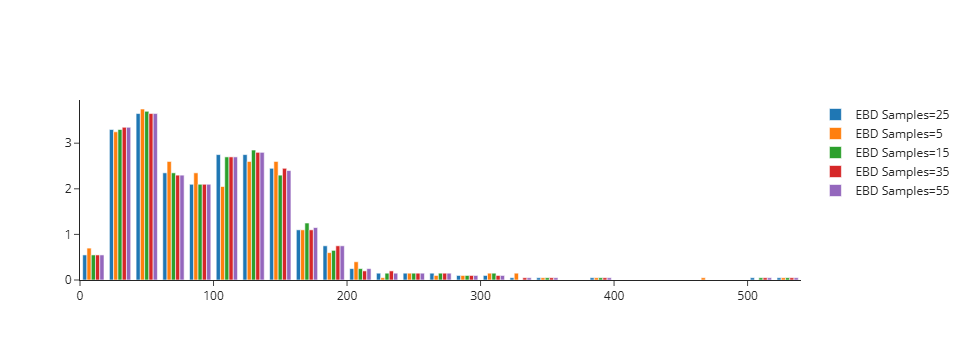

In [104]:
histograms = []
for i in estimates.columns:
    histograms.append(go.Histogram(x=estimates[i], 
                        histnorm='density', name=i, showlegend=True, opacity=1, nbinsx=50))
go.Figure(histograms)